In [6]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from pathlib import Path

In [7]:
data_path = Path("../data")
final_df = pd.read_csv("./final_data.csv", sep=",")

In [8]:
final_df

,duration,nr.employed,euribor3m,emp.var.rate,previous,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,...,month_nov,month_oct,month_sep,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_nonexistent,poutcome_success,y
0,0.010471,0.331680,0.712460,0.648092,-0.349494,0,0,1,0,0,...,0,0,0,1,0,0,0,1,0,0
1,-0.421501,0.331680,0.712460,0.648092,-0.349494,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
2,-0.124520,0.331680,0.712460,0.648092,-0.349494,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
3,-0.413787,0.331680,0.712460,0.648092,-0.349494,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
4,0.187888,0.331680,0.712460,0.648092,-0.349494,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,0.292025,-2.815697,-1.495186,-0.752343,-0.349494,0,0,0,0,1,...,1,0,0,0,0,0,0,1,0,1
41184,0.481012,-2.815697,-1.495186,-0.752343,-0.349494,1,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
41185,-0.267225,-2.815697,-1.495186,-0.752343,-0.349494,0,0,0,0,1,...,1,0,0,0,0,0,0,1,0,0
41186,0.708569,-2.815697,-1.495186,-0.752343,-0.349494,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,1


In [9]:
final_df['y']

0        0
1        0
2        0
3        0
4        0
        ..
41183    1
41184    0
41185    0
41186    1
41187    0
Name: y, Length: 41188, dtype: int64

In [10]:
X = torch.tensor(final_df.drop("y", axis=1).values, dtype=torch.float32)
y = torch.tensor(final_df["y"].values, dtype=torch.float32)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [12]:
X_train.shape

torch.Size([32950, 44])

In [13]:
# wrap the data in tensordataset
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

**Training the Neural Network**

In [15]:
class BinaryClassifier(nn.Module):
    def __init__(self, input_dim):
        super(BinaryClassifier, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)  
        )

    def forward(self, x):
        return self.model(x)
    
model = BinaryClassifier(input_dim=44)
criterion = nn.BCEWithLogitsLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [16]:
import matplotlib.pyplot as plt

num_epochs = 100
losses = []  
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0

    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X).squeeze()
        loss = criterion(outputs, batch_y.float())
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_loader)
    losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")


Epoch 1/100, Loss: 0.2034
Epoch 2/100, Loss: 0.1890
Epoch 3/100, Loss: 0.1856
Epoch 4/100, Loss: 0.1836
Epoch 5/100, Loss: 0.1810
Epoch 6/100, Loss: 0.1786
Epoch 7/100, Loss: 0.1763
Epoch 8/100, Loss: 0.1749
Epoch 9/100, Loss: 0.1738
Epoch 10/100, Loss: 0.1717
Epoch 11/100, Loss: 0.1703
Epoch 12/100, Loss: 0.1687
Epoch 13/100, Loss: 0.1688
Epoch 14/100, Loss: 0.1663
Epoch 15/100, Loss: 0.1653
Epoch 16/100, Loss: 0.1643
Epoch 17/100, Loss: 0.1631
Epoch 18/100, Loss: 0.1622
Epoch 19/100, Loss: 0.1608
Epoch 20/100, Loss: 0.1605
Epoch 21/100, Loss: 0.1588
Epoch 22/100, Loss: 0.1579
Epoch 23/100, Loss: 0.1576
Epoch 24/100, Loss: 0.1564
Epoch 25/100, Loss: 0.1553
Epoch 26/100, Loss: 0.1538
Epoch 27/100, Loss: 0.1533
Epoch 28/100, Loss: 0.1527
Epoch 29/100, Loss: 0.1528
Epoch 30/100, Loss: 0.1514
Epoch 31/100, Loss: 0.1506
Epoch 32/100, Loss: 0.1499
Epoch 33/100, Loss: 0.1486
Epoch 34/100, Loss: 0.1486
Epoch 35/100, Loss: 0.1475
Epoch 36/100, Loss: 0.1470
Epoch 37/100, Loss: 0.1455
Epoch 38/1

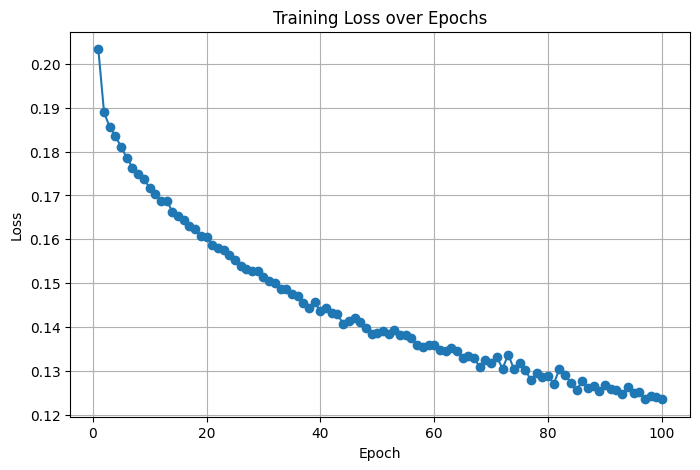

In [17]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs + 1), losses, marker='o')
plt.title("Training Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

In [18]:
def evaluate(model, X, y):
    model.eval()
    with torch.no_grad():
        outputs = torch.sigmoid(model(X).squeeze())
        preds = (outputs > 0.5).float()
        acc = (preds == y).float().mean()
    return acc.item()

accuracy = evaluate(model, X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")


Test Accuracy: 0.9068


In [19]:
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [20]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        probs = torch.sigmoid(outputs)
        preds = (probs > 0.3).int()

        all_preds.extend(preds.view(-1).tolist())
        all_labels.extend(y_batch.view(-1).tolist())

In [21]:
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Accuracy: 0.9001
Precision: 0.5418
Recall: 0.7328
F1 Score: 0.6230


In [22]:

final_df['y'].value_counts(normalize=True)

y
0    0.887346
1    0.112654
Name: proportion, dtype: float64